In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

In [69]:
def preparar_datos(df):
    df = df.copy()
    data = df.groupby('fecha', as_index=False)['monto_recibido'].sum()

    print(f"Datos agrupados por día: {len(data)} registros.")
    print(data.head())

    return data


def dividir_series(data):
    n = len(data)
    train_size = int(n * 0.7)
    val_size = int(n * 0.15)

    train = data[:train_size]
    val = data[train_size:train_size + val_size]
    test = data[train_size + val_size:]

    trainval = pd.concat([train, val])

    return train, val, test, trainval


def prueba_adf(serie):
    resultado = adfuller(serie)
    print(f"ADF: {resultado[0]:.4f} | p-value: {resultado[1]:.4f}")

    if resultado[1] > 0.05:
        print("↳ Serie no estacionaria. Aplicando primera diferenciación...\n")
        serie_diff = serie.diff().dropna()

        resultado_diff = adfuller(serie_diff)
        print(f"ADF (1ra diferencia): {resultado_diff[0]:.4f} | p-value: {resultado_diff[1]:.4f}")

        if resultado_diff[1] > 0.05:
            print("↳ La serie aún no es estacionaria. Se recomienda aplicar una segunda diferenciación.\n")
        else:
            print("↳ La serie es estacionaria después de la primera diferenciación.\n")

        return serie_diff
    else:
        print("↳ Serie estacionaria.\n")
        return serie


def seleccionar_mejor_arima(train, m=None):
    modelo = auto_arima(
        train,
        start_p=0, start_q=0,
        max_p=5, max_q=5,
        d=None,
        seasonal=(m is not None),
        m=m if m else 1,
        trace=True,
        error_action='ignore',
        suppress_warnings=True,
        stepwise=True
    )

    print("\nMejor modelo encontrado:", modelo.order)
    if m:
        print("Estacionalidad:", modelo.seasonal_order)
    print("AIC:", modelo.aic())

    return modelo.order


def evaluar_modelo(real, pred):
    mae = mean_absolute_error(real, pred)
    rmse = np.sqrt(mean_squared_error(real, pred))
    smape = 100 * np.mean(2 * np.abs(pred - real) / (np.abs(real) + np.abs(pred)))
    mape = 100 * np.mean(np.abs((real - pred) / real))
    r2 = r2_score(real, pred)
    metricas = pd.DataFrame({
        'Métrica': ['MAE', 'RMSE', 'sMAPE', 'MAPE', 'R2'],
        'Valor': [mae, rmse, f"{smape:.2f}%", f"{mape:.2f}%", f"{r2:.2f}"]
    })
    print(metricas)
    return metricas

In [74]:
def graficar(train, val, test, pred):
    train['fecha'] = pd.to_datetime(train['fecha'])
    val['fecha']   = pd.to_datetime(val['fecha'])
    test['fecha']  = pd.to_datetime(test['fecha'])

    # Colores brillantes tipo "flare"
    color_train = '#FFA500'   # naranja
    color_val   = '#FF6347'   # rojo tomate
    color_test  = '#1E90FF'   # azul dodger
    color_pred  = '#000000'   # negro para predicción

    # ========================
    # GRÁFICO 1: Serie completa
    # ========================
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(train['fecha'], train['monto_recibido'], label='Train', color=color_train, linewidth=2)
    ax.plot(val['fecha'], val['monto_recibido'], label='Validation', color=color_val, linewidth=2)
    ax.plot(test['fecha'], test['monto_recibido'], label='Test', color=color_test, linewidth=2)
    ax.plot(test['fecha'], pred, '--', label='Predicción ARIMA', color=color_pred, linewidth=2)

    ax.set_title("Predicción ARIMA", fontsize=16, fontweight='bold')
    ax.set_xlabel("Fecha", fontsize=12)
    ax.set_ylabel("Total Venta", fontsize=12)

    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.4, color='gray')

    for pos in ['top', 'right', 'left', 'bottom']:
        ax.spines[pos].set_visible(False)

    plt.tight_layout()
    plt.show()

    # ========================
    # GRÁFICO 2: Real vs Predicción
    # ========================
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(test['fecha'], test['monto_recibido'], label='Real', color=color_test, linewidth=2)
    ax.plot(test['fecha'], pred, '--', label='Predicción', color=color_pred, linewidth=2)

    ax.set_title("Real vs Predicción", fontsize=16, fontweight='bold')
    ax.set_xlabel("Fecha", fontsize=12)
    ax.set_ylabel("Total Venta", fontsize=12)

    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.3, color='gray')

    for pos in ['top', 'right', 'left', 'bottom']:
        ax.spines[pos].set_visible(False)

    plt.tight_layout()
    plt.show()

    # ========================
    # GRÁFICO 3: Distribución del error
    # ========================
    error = abs(test['monto_recibido'] - pred)

    plt.figure(figsize=(14,6))
    plt.scatter(test['fecha'], error, alpha=0.6, color='crimson')
    plt.axhline(0, linestyle='--', color='gray')
    plt.title("Error a lo largo del tiempo")
    plt.xlabel("Fecha")
    plt.ylabel("Error Absoluto")
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.show()

In [71]:
df = pd.read_csv('../output/dataset_venta.csv')

print("\nPreparando datos...")
data = preparar_datos(df)

train, val, test, trainval = dividir_series(data)
print(f"Train={len(train)} | Validation={len(val)} | Test={len(test)}")

print("\nVerificando estacionariedad de la serie...")
prueba_adf(train['monto_recibido'])

print("\nSeleccionando mejor modelo ARIMA por AIC...")
mejor_order = seleccionar_mejor_arima(train['monto_recibido'])

modelo_final = ARIMA(trainval['monto_recibido'], order=mejor_order).fit()

pred_test = modelo_final.forecast(steps=len(test))

evaluar_modelo(test['monto_recibido'], pred_test)


Preparando datos...
Datos agrupados por día: 1930 registros.
        fecha  monto_recibido
0  2019-01-07         5651.05
1  2019-01-08         4285.00
2  2019-01-09        15455.00
3  2019-01-10         5024.50
4  2019-01-11         6350.50
Train=1351 | Validation=289 | Test=290

Verificando estacionariedad de la serie...
ADF: -4.4119 | p-value: 0.0003
↳ Serie estacionaria.


Seleccionando mejor modelo ARIMA por AIC...
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=23814.422, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=23470.601, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=23059.500, Time=1.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=23812.427, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=23060.076, Time=0.78 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=23060.058, Time=1.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=23064.998, Time=0.70 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=23057.803, Time=0.12 s

,Métrica,Valor
0,MAE,596.811126
1,RMSE,740.610768
2,sMAPE,33.41%
3,MAPE,44.63%
4,R2,-0.01


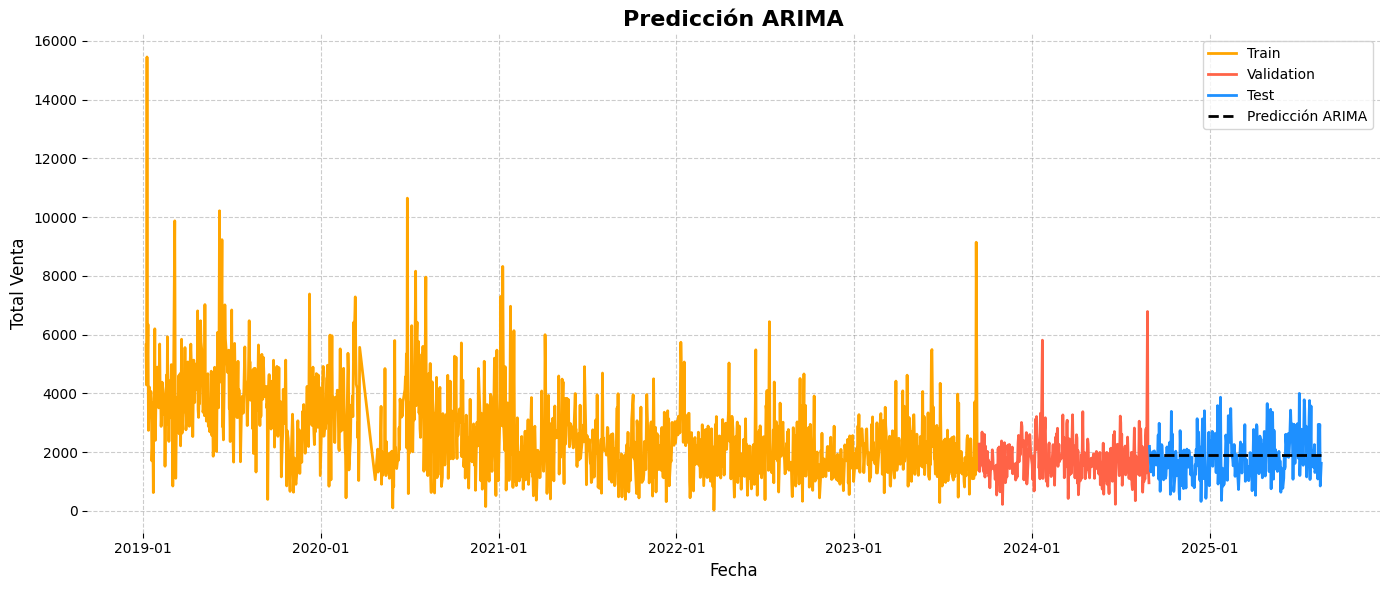

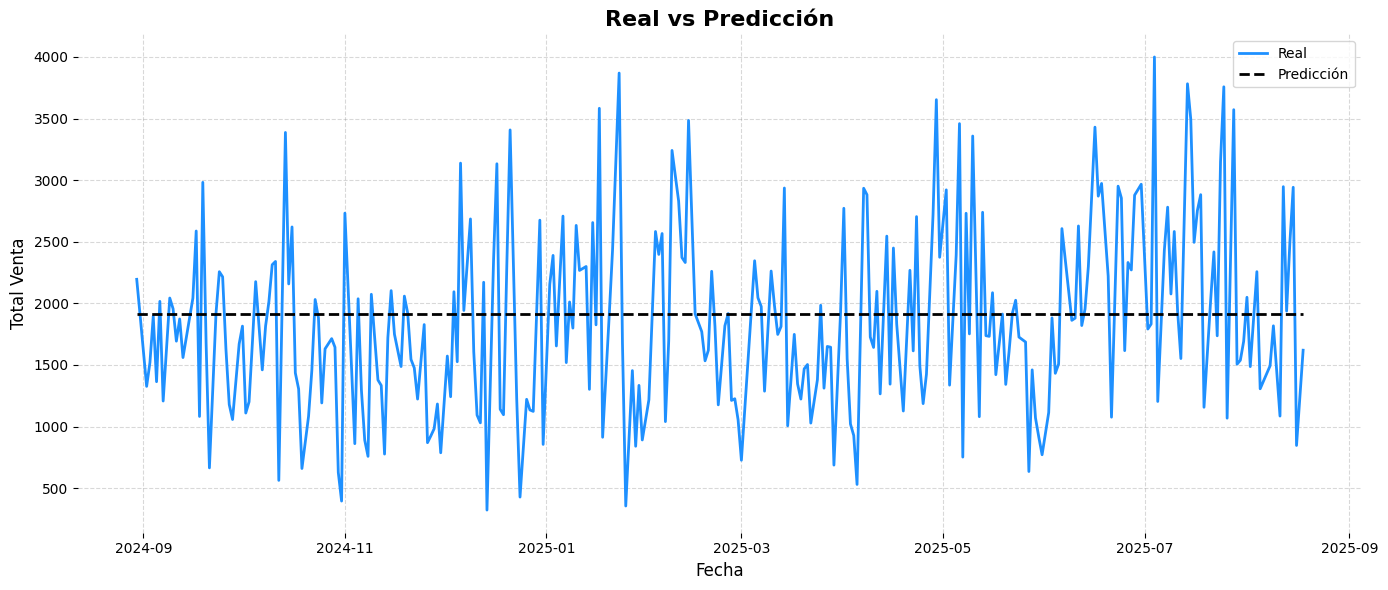

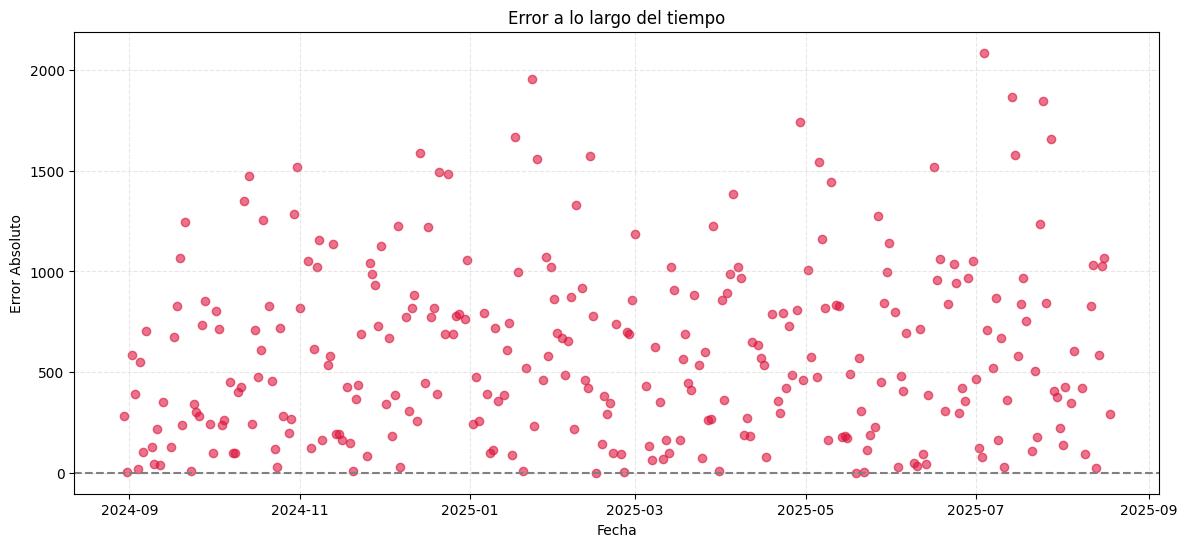

In [75]:
graficar(train, val, test, pred_test)

In [73]:
df_pred = pd.DataFrame({
    'fecha': test['fecha'].values,
    'real': test['monto_recibido'].values,
    'prediccion': pred_test
})

df_pred.to_csv(f"../output/prediccion_arima.csv", index=False)
print(f"Predicción exportada: prediccion_arima.csv")

Predicción exportada: prediccion_arima.csv
